<a href="https://colab.research.google.com/github/jdmarshall95/ML-DL-Labs/blob/main/LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Теория
Загрузим библиотеки

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

Вот так выглядят графики критериев информативности $H(X)$

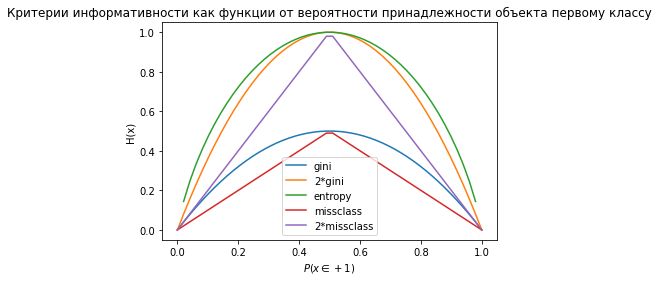

In [ ]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('$P(x \in +1)$')
plt.ylabel('H(x)')
plt.title('Критерии информативности как функции от вероятности принадлежности объекта первому классу')
plt.legend();

# Практика
Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bmw_pricing_challenge.csv', sep=',')
data.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   maker_key          4843 non-null   object
 1   model_key          4843 non-null   object
 2   mileage            4843 non-null   int64 
 3   engine_power       4843 non-null   int64 
 4   registration_date  4843 non-null   object
 5   fuel               4843 non-null   object
 6   paint_color        4843 non-null   object
 7   car_type           4843 non-null   object
 8   feature_1          4843 non-null   bool  
 9   feature_2          4843 non-null   bool  
 10  feature_3          4843 non-null   bool  
 11  feature_4          4843 non-null   bool  
 12  feature_5          4843 non-null   bool  
 13  feature_6          4843 non-null   bool  
 14  feature_7          4843 non-null   bool  
 15  feature_8          4843 non-null   bool  
 16  price           

В этот раз минимально очистим данные:

In [ ]:
data.drop(['maker_key','model_key'],axis=1,inplace=True)
data['RegistrationDate'] = [1 if(i>="1990-03-01" and i<"2000-01-01") else 2 if(i>="2000-01-01" and i<"2010-01-01")
                            else 3 for i in data['registration_date']]
data['SoldAt'] =[1 if(i=="2018-01-01") else 2 if(i=="2018-02-01") else 3 if(i=="2018-03-01")
                 else 4 if(i=="2018-04-01") else 5 if(i=="2018-05-01") else 6 if(i=="2018-06-01")
                 else 7 if(i=="2018-07-01") else 8 if(i=="2018-08-01")
                 else 9 if(i=="2018-09-01") else 0 for i in data['sold_at']]
data['fuel'] = data['fuel'].replace("diesel",1)
data['fuel'] = data['fuel'].replace("petrol",2)
data['fuel'] = data['fuel'].replace("hybrid_petrol",3)
data['fuel'] = data['fuel'].replace("electro",4)
data['paint_color'] = data['paint_color'].replace("black",1)
data['paint_color'] = data['paint_color'].replace("grey",2)
data['paint_color'] = data['paint_color'].replace("white",3)
data['paint_color'] = data['paint_color'].replace("red",4)
data['paint_color'] = data['paint_color'].replace("silver",5)
data['paint_color'] = data['paint_color'].replace("blue",6)
data['paint_color'] = data['paint_color'].replace("orange",7)
data['paint_color'] = data['paint_color'].replace("beige",8)
data['paint_color'] = data['paint_color'].replace("brown",9)
data['paint_color'] = data['paint_color'].replace("green",10)
data['car_type'].unique()
data['car_type'] = data['car_type'].replace("convertible",1)
data['car_type'] = data['car_type'].replace("coupe",2)
data['car_type'] = data['car_type'].replace("estate",3)
data['car_type'] = data['car_type'].replace("hatchback",4)
data['car_type'] = data['car_type'].replace("sedan",5)
data['car_type'] = data['car_type'].replace("subcompact",6)
data['car_type'] = data['car_type'].replace("suv",7)
data['car_type'] = data['car_type'].replace("van",8)
data['feature_1'] = data['feature_1'].replace(True,1)
data['feature_1'] = data['feature_1'].replace(False,0)
data['feature_2'] = data['feature_2'].replace(True,1)
data['feature_2'] = data['feature_2'].replace(False,0)
data['feature_3'] = data['feature_3'].replace(True,1)
data['feature_3'] = data['feature_3'].replace(False,0)
data['feature_4'] = data['feature_4'].replace(True,1)
data['feature_4'] = data['feature_4'].replace(False,0)
data['feature_5'] = data['feature_5'].replace(True,1)
data['feature_5'] = data['feature_5'].replace(False,0)
data['feature_6'] = data['feature_6'].replace(True,1)
data['feature_6'] = data['feature_6'].replace(False,0)
data['feature_7'] = data['feature_7'].replace(True,1)
data['feature_7'] = data['feature_7'].replace(False,0)
data['feature_8'] = data['feature_8'].replace(True,1)
data['feature_8'] = data['feature_8'].replace(False,0)
data.drop(['registration_date','sold_at'],axis=1,inplace=True)
data.head()

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,RegistrationDate,SoldAt
0,140411,100,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,11300,3,1
1,13929,317,2,2,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,69700,3,2
2,183297,120,1,3,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10200,3,2
3,128035,135,1,4,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,25100,3,2
4,97097,160,1,5,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,33400,3,4


In [ ]:
labels = data[['feature_1']]
print("Check labels:", labels.head(3))
features = data.drop(['feature_1'], axis=1)
print("Check features:", features.head(3))

Check labels:    feature_1
0        1.0
1        1.0
2        0.0
Check features:    mileage  engine_power  fuel  ...  price  RegistrationDate  SoldAt
0   140411           100     1  ...  11300                 3       1
1    13929           317     2  ...  69700                 3       2
2   183297           120     1  ...  10200                 3       2

[3 rows x 15 columns]


In [ ]:
labels.shape, features.shape

((4843, 1), (4843, 15))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4)
print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))

Number of training samples:  2905
Number of testing samples:  1938


In [ ]:
from sklearn.tree import DecisionTreeClassifier
simple_tree = DecisionTreeClassifier()
simple_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

y_pred =  simple_tree.predict(X_test)
print('Test data prediction score: ', accuracy_score(y_true = y_test, y_pred = y_pred))
print('Test data CV mean: ', np.mean(cross_val_score(simple_tree, X_train, y_train, cv=5)))
cross_val_score(simple_tree, X_train, y_train, cv=5)

Test data prediction score:  0.6713106295149639
Test data CV mean:  0.6733218588640275


array([0.66609294, 0.65748709, 0.6626506 , 0.66092943, 0.67986231])

Как мы видим, в нашем случае кросс валидация помогла совсем немного повысить точность предсказания модели.

#Случайный лес

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True)
rfc = RandomForestClassifier(n_jobs=-1, oob_score=True)

In [ ]:
rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)

print("Accuracy score: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Accuracy score: 73.99%


In [ ]:
results = cross_val_score(rfc, features, labels, cv=skf)

# Оцениваем точность на тестовом датасете с помощью кросс валидации
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 75.55%


Кросс-валидация увеличила точность предсказания на ~1.5%.

In [ ]:
rfc.feature_importances_

array([0.17994117, 0.14432137, 0.010006  , 0.0731716 , 0.06156906,
       0.05538862, 0.03859614, 0.02031596, 0.03357486, 0.02122078,
       0.03204039, 0.02399253, 0.19334342, 0.01619703, 0.09632107])

Как мы видим, практически все признаки (в виду малочисленности) обладают достаточной значимостью.

# Вариации параметров
Начнем изменять основные параметры

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 75.08% with 100 trees


Выведем наши показатели на график:

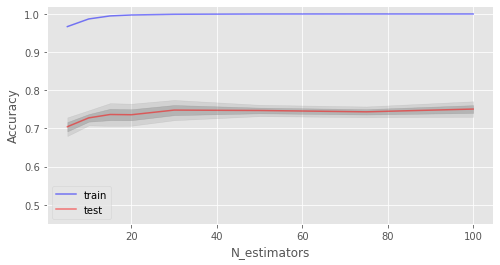

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.45,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

Так как видно переобученеи модели (резкое падение точности на тестовой выборке), добавим параметры регуляризации.

In [ ]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 75.55% with 21 max_depth


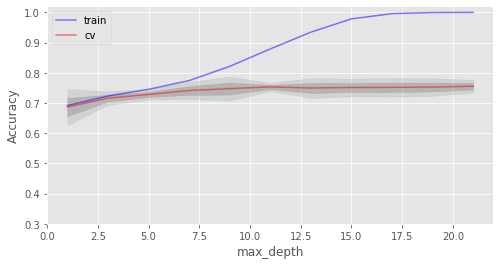

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.3,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("max_depth");

Как мы видим, переобучение удалось частично побороть. Теперь ограничим число листьев.

In [ ]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 75.55% with 3 min_samples_leaf


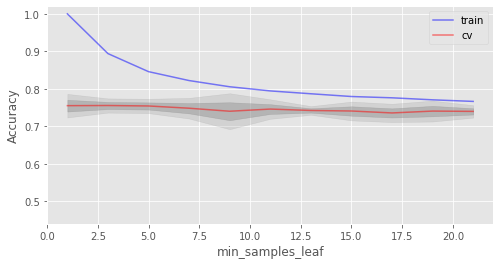

In [ ]:


fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("min_samples_leaf");



In [ ]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 75.92% with 9 max_features


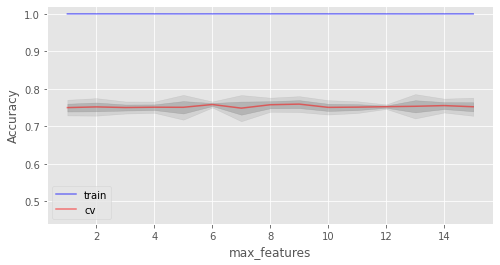

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("max_features");

Найдем оптимальные параметры с помощью GridSearchCV

In [ ]:

# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [3, 5, 7, 10], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=100, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(features, labels)



Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [ ]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=15, max_features=7, min_samples_leaf=3,
                        n_jobs=-1, oob_score=True), 0.7641947905739068)

Лучшая точность 76.41% при параметрах max_depth=15, max_features=7, min_samples_leaf=3 что на ~1% лучше случайного леса без регуляризации и на ~3% лучше одиночного дерева.

#Градиентный бустинг

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

!pip install catboost
from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth).fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)


Выходные данные были обрезаны до нескольких последних строк (5000).
Learning rate set to 0.5
0:	learn: 0.4690673	total: 2.02ms	remaining: 44.5ms
1:	learn: 0.4561720	total: 5.55ms	remaining: 58.3ms
2:	learn: 0.4414404	total: 9.93ms	remaining: 66.2ms
3:	learn: 0.4344686	total: 19.4ms	remaining: 92ms
4:	learn: 0.4317323	total: 26.3ms	remaining: 94.5ms
5:	learn: 0.4289064	total: 28.7ms	remaining: 81.3ms
6:	learn: 0.4275675	total: 33.6ms	remaining: 76.8ms
7:	learn: 0.4257758	total: 36.3ms	remaining: 68.2ms
8:	learn: 0.4234147	total: 43.2ms	remaining: 67.2ms
9:	learn: 0.4222191	total: 48.8ms	remaining: 63.4ms
10:	learn: 0.4209198	total: 52.6ms	remaining: 57.4ms
11:	learn: 0.4194103	total: 66.3ms	remaining: 60.8ms
12:	learn: 0.4181542	total: 72.1ms	remaining: 55.4ms
13:	learn: 0.4175997	total: 77.9ms	remaining: 50.1ms
14:	learn: 0.4169198	total: 82.5ms	remaining: 44ms
15:	learn: 0.4156790	total: 87.2ms	remaining: 38.1ms
16:	learn: 0.4151204	total: 91.9ms	remaining: 32.4ms
17:	learn: 0.4146102

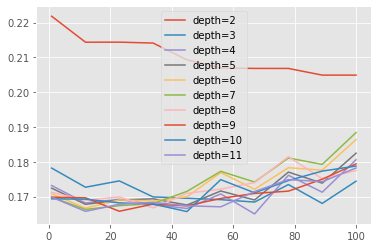

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.legend()

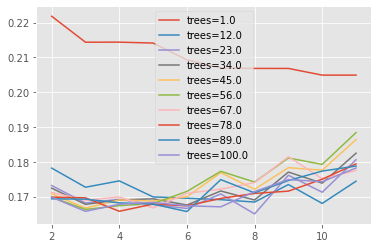

In [ ]:
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.legend()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor(max_depth = 20, max_features = 5, min_samples_leaf = 1).fit(X_train, y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.39926472678359837


#Применение классификатора дерева решений
Я создал конвейер StandardScaler и DT Classifier. Мы можем импортировать классификатор DT как из sklearn.tree, импортировать DecisionTreeClassifier из Scikit-Learn. Чтобы определить лучшие параметры (критерий разделения и максимальную глубину дерева) для классификатора DT, я также использовал Grid Search Cross Validation.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
pipe_steps = [('scaler', StandardScaler()), ('decsT', DecisionTreeClassifier())]

check_params = {'decsT__criterion':['gini', 'entropy'],
                'decsT__max_depth': np.arange(3,15)}

pipeline = Pipeline(pipe_steps)
print(pipeline)

Pipeline(steps=[('scaler', StandardScaler()),
                ('decsT', DecisionTreeClassifier())])


In [ ]:
from tqdm import tqdm_notebook as tqdm

print("Fitting the data:")
import warnings
warnings.filterwarnings("ignore")

for cv in tqdm(range(3,6)):
  create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
  create_grid.fit(X_train, y_train)
  print("Score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, y_test)))
  print("Best params:")
  print(create_grid.best_params_)
print("End")

Fitting the data:


  0%|          | 0/3 [00:00<?, ?it/s]

Score for 3 fold CV := 0.17
Best params:
{'decsT__criterion': 'gini', 'decsT__max_depth': 3}
Score for 4 fold CV := 0.17
Best params:
{'decsT__criterion': 'gini', 'decsT__max_depth': 3}
Score for 5 fold CV := 0.17
Best params:
{'decsT__criterion': 'entropy', 'decsT__max_depth': 3}
End


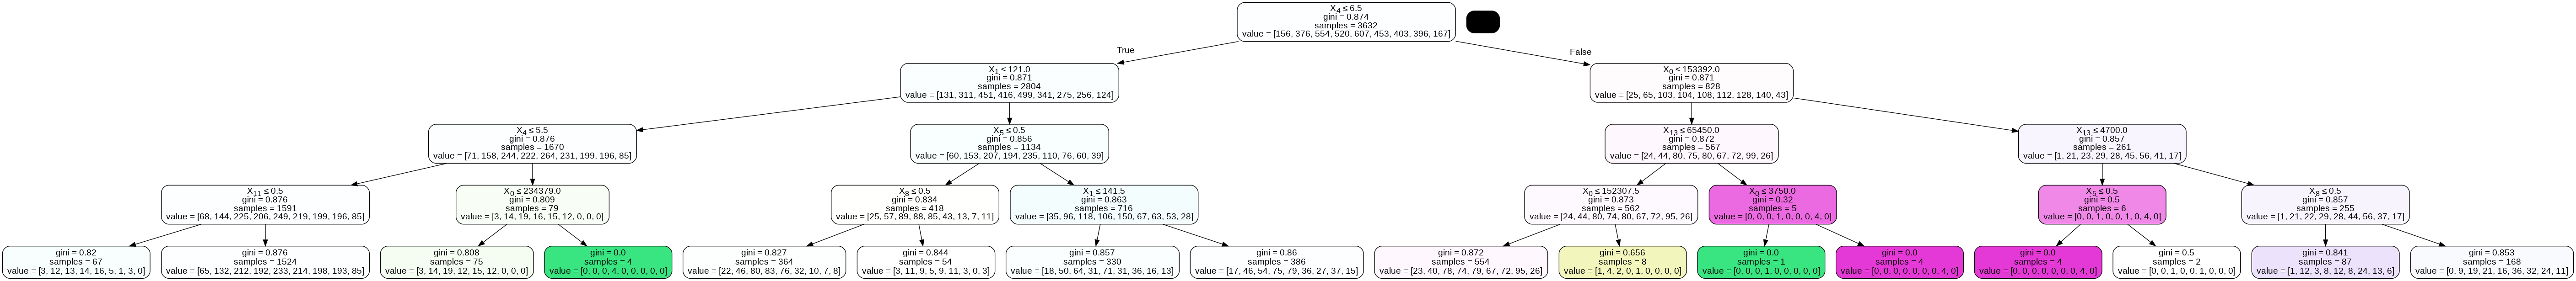

In [ ]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

DecsTree = DecisionTreeClassifier(criterion ='gini', max_depth=4)
DecsTree.fit(X_train, y_train)

dot_data = StringIO()

export_graphviz(DecsTree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Cars_Age_DecsT.png',)
Image(graph.create_png())